Disclaimer

THIS SOFTWARE IS PROVIDED "AS IS" AND ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE
REGENTS OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR
PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT
LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN
IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

Module cash settled swaptions. Primary item contained in this module is class cash_settled_swaptions.Model.

Model
=====

Define Ann(.) as the cash settled annuity formula.

  (1)  Ann(y, s) = df(s, t) * [year fraction] * sum_(cash flow n) (1 + [year fraction] * y) ** -n, 0 <= s <= t
  [See get_annuity(...) for Ann(., t)]

Define the swap-settled forward:

  (2)  y(s) = (y(0) + displacement) * exp{ sigma * W(s) - 1/2 * sigma * sigma * s } - displacement, for 0 <= s <= t
  [See DisplacedLogNormalModel.get_forward(...)]

where W(.) is a Brownian motion.
Analogously, define the cash-settled forward, with its separate displacement and volatility sigma*:

  (3)  y*(s) = (y*(0) + displacement*) * exp{ sigma* * W(s) - 1/2 * sigma* * sigma* * s } - displacement*, for 0 <=s<= t
  [See CashSettledSwaptionModel.get_forward(...)]

Work under the measure associated with the numeraire: Ann(y*(.), .).
To obtain consistency with the cash-settled annuity formula, have y*(0) = y(0).
Under this measure, define the present value of a basis point (aka swap-settled annuity):

  (4)  pvbp(s) = lambda * Ann(y*(s), s) for 0 <= s <= t
  [Does not explicitly occur in the code below]

Note that the numeraire-relative pvbp (pvbp(.) / Ann(y*(.), .))
is a martingale under the chosen measure, by construction.
lambda is chosen to ensure that the value of the pvbp at time zero matches its market value:

  (5)  lambda = pvbp(0) / Ann(y*(0), 0)
  [Does not explicitly occur in the code below]

The numeraire-relative floating leg value y(.) * pvbp(.) is also a martingale under the Ann(y*(.), .)-measure.
The value of a swap-settled payer swaption with strike K is then given by:

  (6)  V(swap settled swaption) = Ann(y*(0), 0) * E[ max(y(t) - K, 0) * pvbp(t) / Ann(y*(t), t) ]
                                = pvbp(0)       * E[ max(y(t) - K, 0) ]
  [See PhysicalSwaptionModel.get_payoff(...)]

Note that this is the standard Black formula under the swap-settled measure.
The swap-settled volatility parameter sigma is therefore naturally equal to the swap settled volatility.
The value of a cash-settled payer swaption is:

  (7)  V(cash settled swaption) = Ann(y*(0), 0) * E[ max(y(t) - K, 0) * Ann(y(t), t) / Ann(y*(t), t) ]
  [See CashSettledSwaptionModel.get_payoff(...) and CashSettledSwaptionModel.diffused_payoff(...)]

which can be efficiently evaluated by numerical quadrature integration (see the calls to integrate.quad routine).

Free parameters
===============

The above model has four freely varying parameters. Denote at-the-money as ATM.
|---------------------------|--------------------------------------------------------------------------------|
| Swap-Settled Volatility	| 1. sigma                                                                       |
|                           | 2. Equal to the market quoted ATM swap settled volatility for ATM              |
|                           | 3. Calibrated to cash settled skew information and put-call parity for non-ATM |
|---------------------------|--------------------------------------------------------------------------------|
| Swap-Settled Displacement | Fixed by the market data                                                       |
|---------------------------|--------------------------------------------------------------------------------|
| Cash-Settled Volatility   | 1. sigma*                                                                      |
|                           | 2. ATM cash-settled vol calibrated to zero-width collar                        |
|                           | 3. Calibrated to cash settled skew information and put-call parity for non-ATM |
|---------------------------|--------------------------------------------------------------------------------|
| Cash-Settled Displacement | 1. Calibrated to the at-the-money zero width collar                            |
|                           | 2. Denoted as displacement*                                                    |
|---------------------------|--------------------------------------------------------------------------------|

Put-call parity
===============

For a given strike K consider long a payer and short a receiver cash settled swaption.
Such package will be referred to as put-call combo (PCC). The payoff of a PCC is:

  (8)  Ann(y(t), t) * (y(t) - K)
  [Does not explicitly occur in the code below]

Now for given strikes K1 and K2 consider a PCC spread, consisting of long a PCC at strike K1 & short a PCC at strike K2.
The payoff of a PCC spread is:

  (9)  Ann(y(t), t) * (K2 - K1)
  [Does not explicitly occur in the code below]

Therefore the value of a PCC spread can be written as:

  (10)  V(PCC spread, K1, K2) = [cash settled convexity adjusted pvbp] * (K2 - K1)
  [See ParityCalibrator.get_parity_error(...)]

where

  (11)  [cash settled convexity adjusted pvbp] = Ann(y*(0), 0) * E[ Ann(y(t), t) / Ann(y*(t), t) ]
  [See CashSettledSwaptionModel.diffused_payoff(...) in which payoff_function(...) is the constant 1.0]

Calibration
===========

The steps to calibrate the model are as follows:

1. Copy swap-settled displacement from the market data.
   See Model.__init__(...)

2. Copy swap-settled ATM volatility from the market data.
   See Model.__init__(...)

3. Calibrate ATM cash-settled volatility and general cash-settled displacement from the ATM zero-width collar value.
   See Model.calibrate(...)

4. Calculate the cash-settled convexity adjusted pvbp according to formula (11).
   See Model.__init__(...): convexity_adjusted_cash_settled_pvbp = integrate(self.atm_model.get_unit_payoff)

5. Calibrate sigma(K) and sigma*(K) to the cash-settled swaption vol & put-call parity relation (10) for other strikes.
   See Model.calibrate_cash_model(...)

Usage Example
=============
import cash_settled_swaptions as css

# calibrate the model using the at-the-money data
model = css.Model(
    forward, displacement, expiry_time, swap_atm_vol, cash_pay_atm_vol,
    cash_receive_atm_vol, cash_annuity_info, cash_pvbp, swap_settled_pvbp,
)

# calibrate to a given cash settled swaption with strike away from ATM
strike_model = model.calibrate_cash_model(strike, cash_strike_vol, css.OptionType.PAYER)

# observe the vols calculated by the strike-model
cash_payer_vol = strike_model.get_implied_vol(css.OptionType.PAYER)
cash_receiver_vol = strike_model.get_implied_vol(css.OptionType.RECEIVER)
swap_payer_vol = strike_model.physical_swaption_model.get_implied_vol(css.OptionType.PAYER)
swap_recv_vol = strike_model.physical_swaption_model.get_implied_vol(css.OptionType.RECEIVER)

Volatility implication for the Black formula
============================================
Otherwise, this module contains a
stand-alone volatility implication function. The stand-alone implementation uses the paper 'By Implication' by
Peter Jaeckel (Wilmott, pages 60-66, November 2006).

In [1]:
import enum
import math
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate
import scipy.optimize
import scipy.stats

DBL_DIG = sys.float_info.dig
DBL_EPSILON = sys.float_info.epsilon  # smallest such that 1.0+DBL_EPSILON != 1.0
DBL_MIN = sys.float_info.min
SQRT_DBL_EPSILON = math.sqrt(DBL_EPSILON)
FOURTH_ROOT_DBL_EPSILON = math.sqrt(SQRT_DBL_EPSILON)
ONE_DIV_SQRT_TWO_PI = 0.3989422804014326779399460599343818684758586311649
UNDERLYING_FLOAT_TENOR_TO_YEAR_FRACTION = {
    '3M': 0.25,
    '6M': 0.5,
    '1Y': 1.0,
    '12M': 1.0
}

In [2]:
class ImpliedVolatility:
    """
    Class to calculate the implied volatility using python. See the paper of Jaeckel 'by implication'
    """

    class OptionType(enum.Enum):
        """
        Option type. call or put
        """
        CALL = 1
        PUT = -1

    @staticmethod
    def intrinsic_value(forward, strike, option_type):
        """
        Intrinsic value of the option
        :param forward: float
        :param strike: float
        :param option_type: OptionType
        :return: float
        """
        return max(float(option_type.value) * (forward - strike), 0.0)

    @staticmethod
    def cube(x):
        """
        Little helper function, calculates x * x * x
        :param x: float
        :return: float
        """
        return x * x * x

    @classmethod
    def normalised_black_call(cls, x, sigma):
        """
        The normalized Black call formula is the one where
        1. the argument x = ln(forward / strike)
        2. its value is b(.) = [black formula] / sqrt(forward * strike)
        :param x: float
        :param sigma: float
        :return: float
        """
        x2 = x * x
        s2 = sigma * sigma
        b_max = math.exp(0.5 * x)
        one_over_b_max = 1.0 / b_max
        if x2 < DBL_EPSILON * s2 or (x2 + s2) < DBL_EPSILON:
            if s2 * s2 > DBL_EPSILON:
                b0 = 1.0 - 2.0 * scipy.stats.norm.cdf(-0.5 * sigma)
            else:
                b0 = ONE_DIV_SQRT_TWO_PI * sigma * (
                    1.0 - s2 * (1.0 / 24.0 - s2 * (1.0 / 640.0 - s2 * (1.0 / 21504.0 - s2 / 884736.0)))
                )
            return max(b0 + 0.5 * x, 0.0)
        xi = x / sigma
        if s2 < DBL_EPSILON * x2:
            phi0 = math.exp(-0.5 * xi * xi) * ONE_DIV_SQRT_TWO_PI
            xi2 = xi * xi
            return max(
                phi0 * math.exp(-0.125 * s2) * 4.0 * sigma / cls.cube(4.0 * xi2 - s2) *
                (8.0 * xi2 * (2.0 * xi2 - s2 - 6.0) + s2 * (s2 - 4.0)),
                0.0,
            )
        return max(
            scipy.stats.norm.cdf(xi + 0.5 * sigma) * b_max - scipy.stats.norm.cdf(xi - 0.5 * sigma) * one_over_b_max,
            0.0
        )

    @staticmethod
    def get_sigma_high(beta, b_c, b_max, phi_c):
        """
        The 'high' initial guess vol function
        :param beta: float
        :param b_c: float
        :param b_max: float
        :param phi_c: float
        :return: float
        """
        return -2.0 * scipy.stats.norm.ppf((b_max - beta) / (b_max - b_c) * phi_c)

    @staticmethod
    def get_sigma_low(beta, ln_b_c, two_x_square, ax):
        """
        The 'low' initial guess vol function
        :param beta: float
        :param ln_b_c: float
        :param two_x_square: float
        :param ax: float
        :return: float
        """
        return math.sqrt(two_x_square / (ax - 4.0 * (math.log(beta) - ln_b_c)))

    @classmethod
    def implied_volatility(cls, input_premium, forward, strike, expiry_time, call_put):
        """
        The Black implied volatility function
        :param input_premium: float
        :param forward: float
        :param strike: float
        :param expiry_time: float
        :param call_put: str. 'call' or 'put'
        :return: float
        """
        option_type = cls.OptionType[call_put.upper()]
        intrinsic = cls.intrinsic_value(forward, strike, option_type)
        if input_premium == intrinsic:
            return 0.0
        if intrinsic >= input_premium:
            raise ValueError(
                "Black implied_volatility: cannot calculate implied volatility if specified premium is less than the "
                "minimum possible price. In this case, the given premium was " + str(input_premium) + " and the "
                "intrinsic value is " + str(intrinsic)
            )
        input_premium_upper_bound = strike if option_type == cls.OptionType.PUT else forward
        if input_premium >= input_premium_upper_bound:
            raise ValueError(
                "Black implied volatility: the given premium is higher than the option price for infinite implied "
                "volatility and thus there is no implied volatility that matches this price."
            )

        premium = input_premium - intrinsic
        # We map everything such that we are solving effectively for equivalent out-of-the-money call options.
        # This means, below we have that effective theta==1, effective x = -|x|
        ax = abs(math.log(forward/strike))
        x = -ax
        beta = premium / math.sqrt(forward * strike)
        ln_beta = math.log(beta)
        b_max = math.exp(0.5 * x)
        sigma_c = math.sqrt(2.0 * ax)
        b_c = cls.normalised_black_call(x, sigma_c)
        phi_c = scipy.stats.norm.cdf(-0.5 * sigma_c)
        sigma_high = cls.get_sigma_high(beta, b_c, b_max, phi_c)
        relative_accuracy = SQRT_DBL_EPSILON * FOURTH_ROOT_DBL_EPSILON
        sigma = sigma_high
        previous_sigma = sys.float_info.max
        beta_less_than_b_c = beta < b_c
        if beta_less_than_b_c:
            sigma_star = cls.get_sigma_high(0, b_c, b_max, phi_c)
            b_star = cls.normalised_black_call(x, sigma_star)
            x2 = x * x
            two_x_square = 2.0 * x2
            ln_b_c = math.log(b_c)
            sigma_low_star = cls.get_sigma_low(b_star, ln_b_c, two_x_square, ax)
            sigma_high_star = cls.get_sigma_high(b_star, b_c, b_max, phi_c)
            gamma = float(
                math.log((sigma_star - sigma_low_star) / (sigma_high_star - sigma_low_star)) / math.log(b_star / b_c)
            )
            xi = beta / b_c
            w = pow(xi, gamma)
            sigma *= w
            sigma += (1.0 - w) * cls.get_sigma_low(beta, ln_b_c, two_x_square, ax)
            if cls.normalised_black_call(x, sigma) < DBL_MIN:
                sigma += sigma_star
                sigma *= 0.5
                if cls.normalised_black_call(x, sigma) < DBL_MIN:
                   sigma += sigma_c
                   sigma *= 0.5
        i = 0
        while i < ((DBL_DIG * 10) / 3) and abs(sigma / previous_sigma - 1.0) > relative_accuracy:
            i += 1
            previous_sigma = sigma
            half_sigma = 0.5 * sigma
            xoversigma = x / sigma
            xoversigma2 = xoversigma * xoversigma
            b = cls.normalised_black_call(x, sigma)
            vega = ONE_DIV_SQRT_TWO_PI * math.exp(-0.5*(xoversigma2+half_sigma*half_sigma))
            vannaovervega = xoversigma2 / sigma - 0.25 * sigma
            if beta_less_than_b_c:
                ln_b = math.log(b)
                nu = max((ln_beta - ln_b) * ln_b / ln_beta * b / vega, -half_sigma)
                eta = max(0.5 * nu * (vannaovervega - (2.0 / ln_b + 1.0) * vega / b), -0.75)
            else:
                nu = max((beta - b) / vega, -half_sigma)
                eta = max(0.5 * nu * vannaovervega, -0.75)
            sigma += max(nu / (1.0 + eta), -half_sigma)
        # The only situations observed thus far when the above iteration doesn't converge within (DBL_DIG*10)/3 == 50
        # iterations are when
        # a) the input option price is non-zero but so small that it is stored as a so-called denormalised floating
        #    point number which means that there aren't enough digits of significance in it to be able to converge to
        #    three quarters of machine accuracy (relative) in sigma
        # b) the input option price is so close to its theoretical maximum such that b_max-beta doesn't contain enough
        #    digits of significance to be able to converge to three quarters of machine accuracy (relative) in sigma
        # In those cases, returning whateve was achieved thus far is an acceptable course of action.
        return sigma / math.sqrt(expiry_time)

In [3]:
# Otherwise, this module contains a
# stand-alone volatility implication function. The stand-alone implementation uses the paper 'By Implication' by
# Peter Jaeckel (Wilmott, pages 60-66, November 2006).
implied_volatility_function = ImpliedVolatility.implied_volatility

In [4]:
class OptionType(enum.Enum):
    """
    Option type
    """
    PAYER = 1
    RECEIVER = -1

In [5]:
def get_annuity(forward, year_fraction, number_payments):
    """
    Cash settled annuity formula. See formula (1)
    :param forward: float
    :param year_fraction: float. Typically 1.0 for yearly, 0.5 semi-annual, etc
    :param number_payments: int
    :return: float
    """
    annuity = 0.0
    tmp = year_fraction
    for j in range(0, number_payments):
        tmp /= 1.0 + year_fraction * forward
        annuity += tmp
    return annuity

In [6]:
class CashAnnuityInfo:
    """
    Simple class to contain the information for the annuity formula: the year fraction and the number of payments
    """
    def __init__(self, year_fraction, number_payments):
        """
        Create a CashAnnuityInfo
        :param year_fraction: float, for example 0.5 for semi-annual, 1.0 for annual, etc.
        :param number_payments: int
        """
        self.year_fraction = year_fraction
        self.number_payments = number_payments

    def get_annuity(self, forward):
        """
        Calculate the cash-settled annuity
        :param forward: float
        :return: float
        """
        return get_annuity(forward=forward, year_fraction=self.year_fraction, number_payments=self.number_payments)

In [7]:
def get_implied_vol(premium, displacement, option_type, forward, expiry_time, strike, pvbp):
    """
    Get the implied volatility
    :param premium: float, the premium
    :param displacement: float. Typically > 0.0, e.g. 0.03
    :param option_type: OptionType
    :param forward: float
    :param expiry_time: float, time expressed as ACT/365
    :param strike: float
    :param pvbp: present value of a basis point
    :return: float
    """
    option_type_to_call_put = {OptionType.PAYER: 'call', OptionType.RECEIVER: 'put'}
    call_put = option_type_to_call_put[option_type]
    try:
        implied_vol = implied_volatility_function(  # Calculates implied Black vol consistent with given premium
            premium / pvbp,  # premium. The (undiscounted) value of the option
            forward + displacement,  # forward. The par strike of the associated forward contract
            strike + displacement,  # strike. The strike of the option
            expiry_time,  # T. The expiry time in years
            call_put,  # optionType. "Call" or "Put"
        )
        return implied_vol
    except Exception as _:
        return None

In [8]:
def kernel(x, f, *args):
    """
    The kernel function
    :param x: float. Gaussian deviate
    :param f: function to integrate
    :param args: list. Additional arguments for function f
    :return: float
    """
    return 1.0 / ((2.0 * math.pi) ** 0.5) * f(x, *args) * math.exp(-0.5 * x ** 2)

In [9]:
def integrate(f, *args, **kwargs):
    """
    Integrate the function f over the kernel
    :param f: function
    :param args: list. Additional arguments for function f
    :param kwargs: dict. Key word arguments
    :return: tuple where the first entry represents the resulting integral value
    """
    return scipy.integrate.quad(kernel, -np.inf, np.inf, (f, *args), **kwargs)

In [10]:
class DisplacedLogNormalModel:
    """
    Displaced Log-normal model
    """

    def __init__(self, model, displacement, vol):
        """
        Initiate a model
        :param model: Model
        :param displacement: float
        :param vol: float
        """
        self.model = model
        self.forward = model.forward
        self.displacement = displacement
        self.expiry_time = model.expiry_time
        self.vol = vol
        self.integrate_quad_options_dict = model.integrate_quad_options_dict
        self.strike = None  # :param strike: float. Not used in the base class, used in derived classes
        self.pvbp = None  # :param pvbp: float. Not used in the base class, used in derived classes

    def get_forward(self, z):
        """
        Get the diffused forward given a normal deviate z. See formulas (2) and (3).
        :param z: float
        :return: float
        """
        exp_arg = self.vol * math.sqrt(self.expiry_time) * z - 0.5 * self.vol * self.vol * self.expiry_time
        exp_arg = min(exp_arg, math.log(sys.float_info.max))
        exp = math.exp(exp_arg)
        forward = (self.forward + self.displacement) * exp - self.displacement
        return forward

    def get_implied_volatility(self, option_type, value):
        """
        Imply the vol
        :param option_type: OptionType
        :param value: float (premium)
        :return: float
        """
        implied_vol = get_implied_vol(
            premium=value,
            displacement=self.model.displacement,
            option_type=option_type,
            forward=self.forward,
            expiry_time=self.expiry_time,
            strike=self.strike,
            pvbp=self.pvbp,
        )
        return implied_vol

    def get_implied_vol(self, option_type):
        """
        Integrate the model and imply the vol
        :param option_type: OptionType
        :return: float
        """
        model_value = self.integrate(self.get_payoff, option_type)
        result = self.get_implied_volatility(option_type=option_type, value=model_value)
        return result

    def get_payoff(self, *args):
        """
        No payoff in the base class, used in derived classes
        :param args:
        :return:
        """
        raise NotImplementedError()

In [11]:
class PhysicalSwaptionModel(DisplacedLogNormalModel):
    """
    Physical Swaption model using displaced log-normal
    """

    def __init__(self, model, vol, strike):
        """
        Create a Physical swaption model
        :param model: Model
        :param vol: float
        :param strike: float
        """
        DisplacedLogNormalModel.__init__(
            self,
            model=model,
            displacement=model.displacement,
            vol=vol,
        )
        self.strike = strike
        self.pvbp = model.swap_settled_pvbp

    def get_payoff(self, x, option_type):
        """
        Get the diffused payoff given a Gaussian deviate x and a pay/receive code. See formula (6)
        :param x: float, Gaussian deviate
        :param option_type: OptionType
        :return: float
        """
        forward = self.get_forward(x)
        result = max(float(option_type.value) * (forward - self.strike), 0.0) * self.pvbp
        return result

In [12]:
class CashSettledSwaptionModel(DisplacedLogNormalModel):
    """
    Cash settled swaption model using displaced log-normal
    """

    def __init__(
            self,
            model,
            strike,
            vol_swap_settled,
            vol_cash_settled,
            displacement_cash_settled,
    ):
        """
        Create a Cash settled swaption model
        :param model: Model
        :param strike: float
        :param vol_swap_settled: float, volatility for swap settled (forecase vol)
        :param vol_cash_settled: float, cash-settled volatility
        :param displacement_cash_settled: float
        """
        self.model = model
        self.physical_swaption_model = PhysicalSwaptionModel(model, vol_swap_settled, strike)
        DisplacedLogNormalModel.__init__(
            self,
            model=model,
            displacement=displacement_cash_settled,
            vol=vol_cash_settled,
        )
        self.strike = strike
        self.pvbp = model.cash_pvbp

    def diffused_payoff(self, x, payoff_function):
        """
        Diffuse the variables and evaluate the numeraire relative payoff. See formula (7)
        :param x: float, Gaussian deviate
        :param payoff_function: a function which expects a diffused forward as input and returns the payoff
        :return: float
        """
        forward = self.physical_swaption_model.get_forward(x)
        forward_cash_settled = self.get_forward(x)
        annuity = self.model.cash_annuity_info.get_annuity(forward)
        numeraire = self.model.cash_annuity_info.get_annuity(forward_cash_settled)
        result = self.pvbp * payoff_function(forward) * annuity / numeraire
        return result

    def get_payoff(self, x, option_type):
        """
        Cash settled swaption payoff
        :param x: float, Gaussian deviate
        :param option_type: OptionType
        :return: float
        """
        def payoff_function(forward):
            return max(float(option_type.value) * (forward - self.strike), 0.0)
        return self.diffused_payoff(x, payoff_function)

    def get_unit_payoff(self, x):
        """
        Get the unit payoff
        :param x: float, Gaussian deviate
        :return: float
        """
        def payoff_function(_):
            return 1.0
        return self.diffused_payoff(x, payoff_function)

    def get_put_call_combo_value(self):
        """
        Get put-call combo value, long a payer, short a receiver
        :return: float
        """
        payer_value = self.integrate(self.get_payoff, OptionType.PAYER)
        receiver_value = self.integrate(self.get_payoff, OptionType.RECEIVER)
        put_call_combo_value = payer_value - receiver_value
        return put_call_combo_value

    def integrate(self, payoff_function, option_type=None):
        """
        Integrate the payoff times numeraire.
        :param payoff_function: a function, typically get_payoff or get_unit_payoff
        :param option_type: OptionType or None, None to be exclusively used for get_unit_payoff
        :return: float
        """
        assert option_type is not None or payoff_function.__name__ == 'get_unit_payoff'
        args = [option_type] if option_type is not None else []
        result = integrate(payoff_function, *args, **self.model.integrate_quad_options_dict)
        return result[0]

In [13]:
class ParityCalibrator:
    """
    Parity calibrator
    """

    def __init__(self, model, option_type, strike, target_vol):
        """
        Create parity calibrator. Calibrate two variables to a cash settled swaption and the parity condition
        :param model: Model
        :param option_type: OptionType
        :param strike: float
        :param target_vol: float
        """
        self.model = model
        self.option_type = option_type
        self.strike = strike
        self.target_vol = target_vol

    def get_parity_error(self, swap_settled_and_cash_settled_vol):
        """
        Get parity error. This is pair of (1) vol error versus a market level and
        (2) the difference between the model's convexity adjusted cash settled pvbp values
        :param swap_settled_and_cash_settled_vol: np.array with 2 entries, swap-settled & cash-settled vol
        :return: float
        """
        swap_settled_vol, cash_settled_vol = swap_settled_and_cash_settled_vol
        model = self.model.get_cash_model(
            cash_settled_vol=cash_settled_vol,
            cash_settled_displacement=self.model.cash_settled_displacement,
            vol=swap_settled_vol,
            strike=self.strike,
        )
        cash_settled_error = model.get_implied_vol(self.option_type) - self.target_vol
        convexity_adjusted_cash_settled_pvbp = \
            (model.get_put_call_combo_value() - self.model.put_call_combo_atm_value) / \
            (self.model.forward - self.strike)  # uses formula (10)
        pvbp_error = convexity_adjusted_cash_settled_pvbp - self.model.convexity_adjusted_cash_settled_pvbp
        return np.array([cash_settled_error, pvbp_error])

In [14]:
class Model:
    """
    The cash settled swaptions model.
    """

    def __init__(
            self,
            forward,
            displacement,
            expiry_time,
            swap_atm_vol,
            cash_pay_atm_vol,
            cash_receive_atm_vol,
            cash_annuity_info,
            cash_pvbp,
            swap_settled_pvbp,
            tol=None,
            integrate_quad_options_dict=None,
            **kwargs
    ):
        """
        Create a model and calibrate it.
        :param forward: float
        :param displacement: float
        :param expiry_time: float
        :param swap_atm_vol: float
        :param cash_pay_atm_vol: float
        :param cash_receive_atm_vol: float
        :param cash_annuity_info: CashAnnuityInfo
        :param cash_pvbp: float
        :param swap_settled_pvbp: float
        :param tol: tolerance for the solver. See documentation for scipy.optimize.root
        :param integrate_quad_options_dict: dict or None (default). Adds additional options to scipy.integrate.quad
        :param kwargs: dict, key word arguments
        """
        self.forward = forward
        self.displacement = displacement  # Calibration step #1: Copy swap-settled displacement from the market data.
        self.expiry_time = expiry_time
        self.swap_atm_vol = swap_atm_vol  # Calibration step #2: Copy swap settled ATM volatility from the market data.
        self.cash_pay_atm_vol = cash_pay_atm_vol
        self.cash_receive_atm_vol = cash_receive_atm_vol
        self.cash_annuity_info = cash_annuity_info
        self.cash_pvbp = cash_pvbp
        self.swap_settled_pvbp = swap_settled_pvbp
        self.tol = tol
        self.integrate_quad_options_dict = {} if integrate_quad_options_dict is None else integrate_quad_options_dict
        # Calibration step #3: Calibrate ATM cash-settled vol & displacement from ATM zero-width collar value.
        self.cash_settled_vol_atm, self.cash_settled_displacement = self.calibrate()
        self.atm_model = self.get_cash_model(self.cash_settled_vol_atm, self.cash_settled_displacement)
        # Calibration step #4: Calculate the cash settled convexity adjusted pvbp according to formula (11).
        convex_adj_cash_settle_pvbp_res = self.atm_model.integrate(self.atm_model.get_unit_payoff)
        self.convexity_adjusted_cash_settled_pvbp = convex_adj_cash_settle_pvbp_res
        self.put_call_combo_atm_value = self.atm_model.get_put_call_combo_value()

    def get_cash_model(self, cash_settled_vol, cash_settled_displacement=None, vol=None, strike=None):
        """
        Get cash model
        :param cash_settled_vol: float
        :param cash_settled_displacement: float or None (default, uses ATM cash-settled displacement in this case)
        :param vol: float. swap settled vol. If left None, use ATM swap-settled vol
        :param strike: float. If None, use forward.
        :return: CashSettledSwaptionModel
        """
        if cash_settled_displacement is None:
            cash_settled_displacement = self.cash_settled_displacement
        if vol is None:
            vol = self.swap_atm_vol
        if strike is None:
            strike = self.forward
        return CashSettledSwaptionModel(
            model=self,
            strike=strike,
            vol_swap_settled=vol,
            vol_cash_settled=cash_settled_vol,
            displacement_cash_settled=cash_settled_displacement,
        )

    def get_zero_width_collar_error(self, cash_settled_vol_and_displacement):
        """
        Get zero-width collar error: pair of difference (model versus target) between payer & receiver cash settled vols
        :param cash_settled_vol_and_displacement: numpy array with two entries, the cash-settled vol & displacement
        :return: numpy array
        """
        target_vols = [(OptionType.PAYER, self.cash_pay_atm_vol), (OptionType.RECEIVER, self.cash_receive_atm_vol)]
        cash_settled_vol, cash_settled_displacement = cash_settled_vol_and_displacement
        vol_diffs = []
        for option_type, target_vol in target_vols:
            model_cash = self.get_cash_model(cash_settled_vol, cash_settled_displacement)
            implied_vol_cash = model_cash.get_implied_vol(option_type)
            vol_diffs.append(implied_vol_cash - target_vol)
        return np.array(vol_diffs)

    def calibrate(self):
        """
        Solve for cash-settled vol & displacement such that the payer & receiver ATM cash settled vols are matched
        :return: pair (tuple) of cash-settled ATM vol and cash-settled displacement
        """
        calibration_result = scipy.optimize.root(
            self.get_zero_width_collar_error,
            np.array([self.swap_atm_vol, self.displacement]),  # initial guess
            tol=self.tol,
        )
        cash_settled_vol_atm, cash_settled_displacement = calibration_result.x
        return cash_settled_vol_atm, cash_settled_displacement

    def calibrate_cash_model(self, strike, vol_cash, option_type):
        """
        Calibrate a cash model at a given strike.
        This function represents calibration step #5:
        Calibrate sigma(K) and sigma*(K) to cash settled swaption vol & put-call parity relation (10) for other strikes.
        :param strike: float
        :param vol_cash: float
        :param option_type: OptionType
        :return: CashSettledSwaptionModel
        """
        if strike == self.forward:
            return self.atm_model
        parity_calibrator = ParityCalibrator(
            model=self,
            option_type=option_type,
            strike=strike,
            target_vol=vol_cash,
        )
        calib_result = scipy.optimize.root(
            parity_calibrator.get_parity_error,
            np.array([vol_cash, self.cash_settled_vol_atm]),  # initial guess
            tol=self.tol,
        )
        vol_swap_settled, vol_cash_settled = calib_result.x
        cash_model = self.get_cash_model(
            cash_settled_vol=vol_cash_settled,
            vol=vol_swap_settled,
            strike=strike,
        )
        return cash_model

In [15]:
FAVOURITE_STRIKE_OFFSETS = [0.0,
    0.000625, 0.00125, 0.0025, 0.0050, 0.0075, 0.01, 0.015, 0.02, 0.03,
    -0.000625, -0.00125, -0.0025, -0.0050, -0.0075, -0.01, -0.015, -0.02, -0.03
]

In [16]:
class SettleType(enum.Enum):
    """
    Settlement type.
    """
    PAY = 1  # cash-settled payer
    RECV = -1  # cash-settled receiver
    PHYSICAL = 0  # swap-settled

In [17]:
def plot_vols(strikes, model, market_cash_payer, market_cash_receiver):
    """
    Plot the model vols
    :param model: Model
    :param market_cash_payer: list of float or None, containing the market cash-settled payer vols
    :param market_cash_receiver: list of float or None, containing the market cash-settled receiver vols
    :return:
    """
    plt.style.use('ggplot')
    model_vols = []
    model_cash_vols = {option_type: [] for option_type in OptionType}
    market_vols = {SettleType.PAY: market_cash_payer, SettleType.RECV: market_cash_receiver}
    for count, strike in enumerate(strikes):

        is_payer = strike > model.forward
        option_type = OptionType.PAYER if is_payer else OptionType.RECEIVER
        settle_type = SettleType.PAY if is_payer else SettleType.RECV

        vol_cash_to_calibrate_to = market_vols[settle_type][count]
        model_cash = model.calibrate_cash_model(strike, vol_cash_to_calibrate_to, option_type)

        implied_vol = model_cash.physical_swaption_model.vol
        model_vols.append(implied_vol)

        for my_option_type in OptionType:
            implied_vol_cash = model_cash.get_implied_vol(my_option_type)
            model_cash_vols[my_option_type].append(implied_vol_cash)

    plt.plot(strikes, model_vols, label='model vols ' + SettleType.PHYSICAL.name)
    for option_type, cash_vols_model in model_cash_vols.items():
        plt.plot(strikes, cash_vols_model, label='model cash {type} vols'.format(type=option_type.name.lower()))

    for settle_type in market_vols.keys():
        plt.plot(strikes, market_vols[settle_type], label='market vols ' + settle_type.name)
    plt.legend()
    plt.title('Swaption volatilities')
    plt.show()

In [18]:
def get_strikes(forward, displacement):
    """
    Get some example set of strikes based on the FAVOURITE_STRIKE_OFFSETS constant
    :param forward: float
    :param displacement: float
    :return: list of float
    """
    strikes = sorted([
        forward + strike_offset
        for strike_offset in FAVOURITE_STRIKE_OFFSETS
        if forward + strike_offset > -displacement
    ])
    return strikes

In [19]:
def main():
    """
    The main function which gets called when this module is ran as a script.
    This main function will set some example values and then it will run the model on the example.
    Subsequently the results are plotted in a figure.
    :return:
    """
    forward = 0.01100343969
    displacement = 0.007  # displacement aka shift
    expiry_time = 30.019178082191782
    vol_physical_measure_atm = 0.2130896096958366  # physical aka swap-settled
    atm_pay_vol = 0.22212766305824355
    atm_rec_vol = 0.1994018397861978
    cash_annuity_info = CashAnnuityInfo(year_fraction=1.0, number_payments=30)
    cash_pvbp = 17.81653454617611
    physical_pvbp = 17.994421329395927
    market_cash_payer = [
        None, None, None, None, None, None, None, 0.22212766305824355, 0.2191166853454672, 0.21625128088540194,
        0.21092449139042832, 0.2016940138299131, 0.19406310229906248, 0.18774926787352228, 0.17821763702783086,
        0.1717397903524143, 0.16444139694677906,
    ]
    market_cash_receiver = [
        0.3779182774820147, 0.2759240484072475, 0.24887266885973108, 0.22840424850890914,
        0.21231444837760344, 0.20551432485314422, 0.20237753128037136, 0.1994018397861978,
        None, None, None, None, None, None, None, None, None,
    ]
    model = Model(
        forward=forward,
        displacement=displacement,
        expiry_time=expiry_time,
        swap_atm_vol=vol_physical_measure_atm,
        cash_pay_atm_vol=atm_pay_vol,
        cash_receive_atm_vol=atm_rec_vol,
        cash_annuity_info=cash_annuity_info,
        cash_pvbp=cash_pvbp,
        swap_settled_pvbp=physical_pvbp,
    )
    strikes = get_strikes(forward=forward, displacement=displacement)
    plot_vols(strikes, model, market_cash_payer, market_cash_receiver)

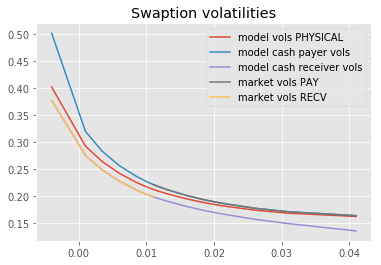

In [21]:
if __name__ == '__main__':
    main()